In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import save_image

/home/taha/.conda/envs/tldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, img_folder, transform=None):
        """
        Args:
            img_folder (str): Path to the folder containing images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.img_folder = img_folder
        self.transform = transform
        self.img_paths = [os.path.join(img_folder, fname) for fname in os.listdir(img_folder) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path)  # Read image using OpenCV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Convert image to float32 for safe addition
        img = img.astype(np.float32)

        # Randomly sample a standard deviation from the range [0, 200]
        std = np.random.uniform(0, 200)

        # Add Gaussian noise
        noise = np.random.normal(0, std, img.shape).astype(np.float32)  # Mean 0, random std
        noisy_img = img + noise

        # Clip values to [0, 255] and convert back to uint8
        noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)

        # Debug printing
        print(f"Image Index: {idx}, Std: {std:.2f}, Image Shape: {img.shape}, Noisy Image Shape: {noisy_img.shape}")

        if self.transform:
            img = self.transform(img.astype(np.uint8))  # Apply transform to original image
            noisy_img = self.transform(noisy_img)       # Apply transform to noisy image

        return img, noisy_img

In [3]:
# Define transformations (optional)
transform = transforms.Compose([
    transforms.ToPILImage(),   # Convert numpy array to PIL image
    transforms.Resize((256, 256)),  # Resize image to 256x256
    transforms.ToTensor(),  # Convert image to Tensor
])

In [5]:
# Load datasets
test_dataset = CustomImageDataset("/home/data/taha/UNET-denoising/celebahq_toy/test", transform=transform)

# Create DataLoaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print dataset size
print(f"Test samples: {len(test_dataset)}")

Test samples: 200


Access First Batch

In [10]:
data_batch = next(iter(test_loader))

Image Index: 0, Std: 78.49, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 1, Std: 72.84, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 2, Std: 191.12, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 3, Std: 36.17, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 4, Std: 113.22, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 5, Std: 112.20, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 6, Std: 171.14, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 7, Std: 93.35, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 8, Std: 37.12, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 9, Std: 57.43, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 10, Std: 8.36, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 11, 

In [15]:
def show_batch(dataloader, rows, columns):
    data_iter = iter(dataloader)
    clean_imgs, noisy_imgs = data_iter.next()  # Unpack the batch into clean and noisy images
    
    total_images = rows * columns
    if total_images > len(clean_imgs):  # Ensure we don't access out-of-bounds images
        total_images = len(clean_imgs)
    
    fig = plt.figure(figsize=(15, 12))
    for i in range(total_images):
        # Plot clean image
        np_clean_img = clean_imgs[i].numpy()  # Convert tensor to numpy
        np_clean_img = np.transpose(np_clean_img, (1, 2, 0))  # Rearrange dimensions
        ax = fig.add_subplot(rows, columns * 2, 2 * i + 1)  # Odd positions for clean images
        ax.imshow(np_clean_img)
        ax.set_title("Clean")
        plt.axis('off')

        # Plot noisy image
        np_noisy_img = noisy_imgs[i].numpy()  # Convert tensor to numpy
        np_noisy_img = np.transpose(np_noisy_img, (1, 2, 0))  # Rearrange dimensions
        ax = fig.add_subplot(rows, columns * 2, 2 * i + 2)  # Even positions for noisy images
        ax.imshow(np_noisy_img)
        ax.set_title("Noisy")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Image Index: 0, Std: 194.68, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 1, Std: 123.06, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 2, Std: 44.89, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 3, Std: 45.69, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 4, Std: 2.98, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 5, Std: 109.71, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 6, Std: 68.75, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 7, Std: 189.46, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 8, Std: 93.85, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 9, Std: 150.93, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 10, Std: 170.05, Image Shape: (256, 256, 3), Noisy Image Shape: (256, 256, 3)
Image Index: 11

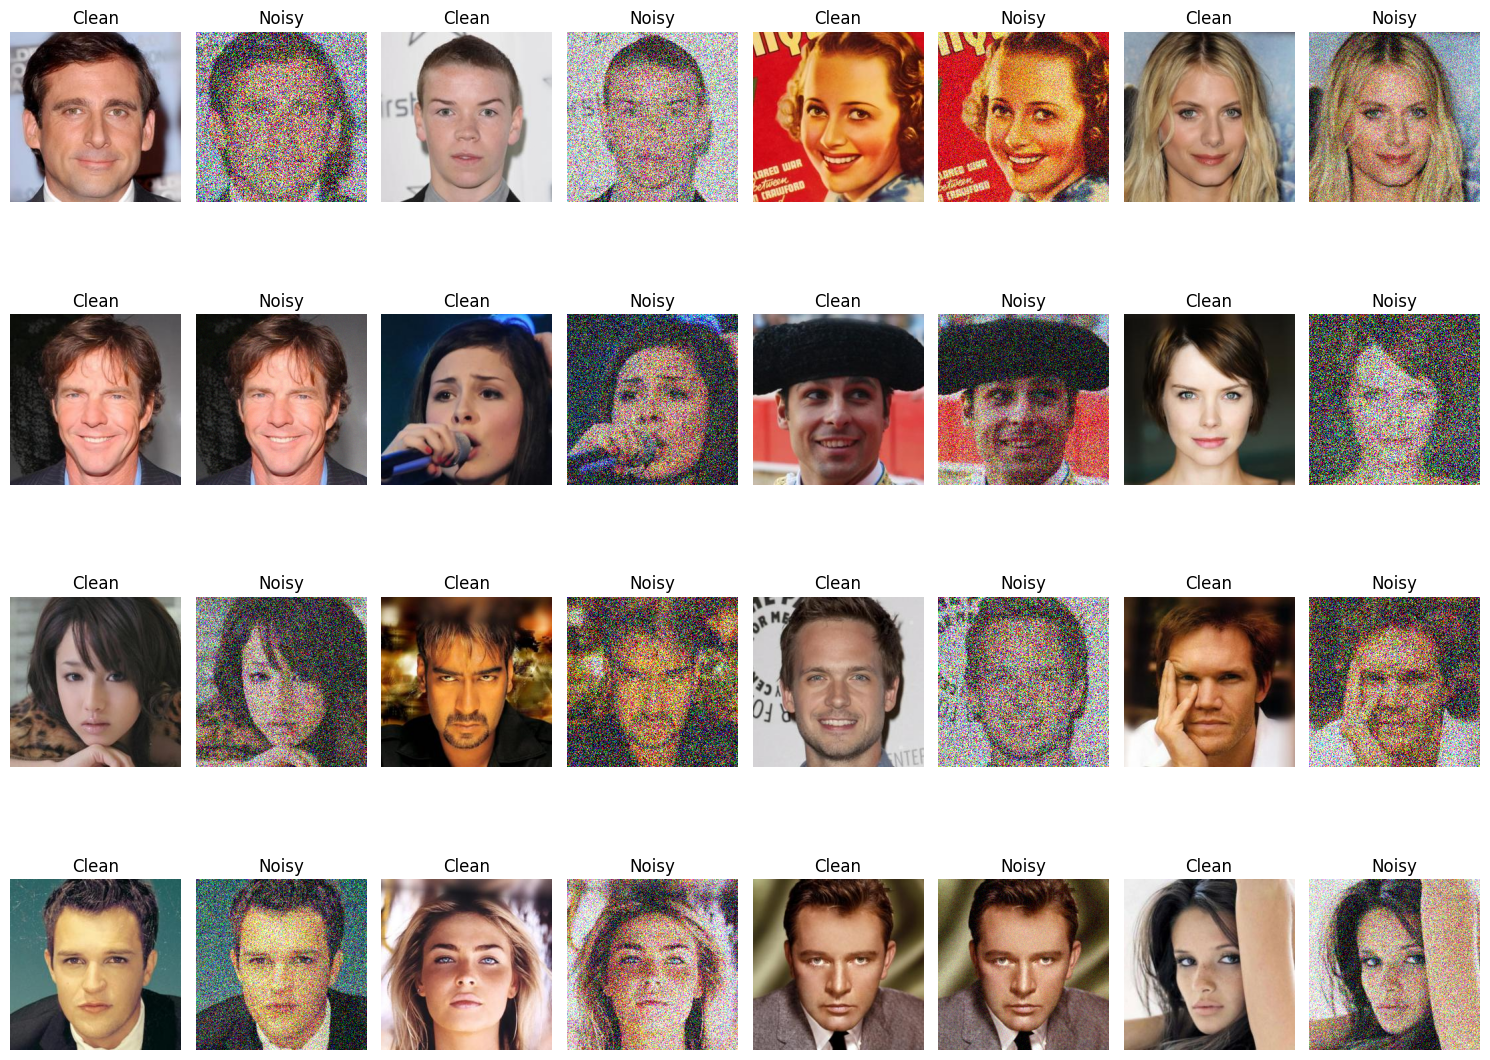

In [16]:
sample_ds=CustomImageDataset("/home/data/taha/UNET-denoising/celebahq_toy/test",transform=transform)
sample_dl=DataLoader(sample_ds,batch_size=16)

show_batch(sample_dl, rows=4, columns=4)
